In [55]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.interpolate import interp1d

from scipy.optimize import root_scalar, least_squares

from shapely import LineString

from pyCivilDesign.sections.concreteSections import RectConcreteSct
import pyCivilDesign.sections.rebarSections as Rsct
import pyCivilDesign.sections.section as Sct
import pyCivilDesign.concreteDesign.LRFDmethod.PMManalysis as PMManalysis
import pyCivilDesign.concreteDesign.designProps as props

In [23]:
d20 = Rsct.d20

sct = RectConcreteSct(b=500, h=700)
sct.rebarCoords = Rsct.RectRebarsSct(sct.section, 5, 4, d20, 50)

data = props.setDesignDataFromSection(sct)

In [98]:
def calc_Pc_list(data, angle, interval=20):
    c_list = np.array([0,], dtype=np.float32)
    P_list = np.array([PMManalysis.calc_Pt_max(data),], dtype=np.float32)
    c=0.1
    while True:
        _P = PMManalysis.calc_P(data, c, angle)
        c_list = np.append(c_list, c)
        P_list = np.append(P_list, _P)
        if (PMManalysis.calc_M(data, c, angle)[0] < 100) and \
           (PMManalysis.calc_P(data, c, angle) > PMManalysis.calc_P0(data)) : break
        c += interval
    return P_list, c_list


def calc_c(data, P, angle):
    def _optim_c(x):
        return PMManalysis.calc_P(data, x, angle) - P
    c_max = calc_c0(data, angle)
    return root_scalar(_optim_c, bracket=[0.0001, c_max]).root


def calc_c0(data, angle):
    def _optim_P0(x):
        return PMManalysis.calc_P(data, x, angle) - PMManalysis.calc_P0(data)
    minx, miny, maxx, maxy = data.section.bounds
    return root_scalar(_optim_P0, x0=maxy-miny, x1=(maxy-miny)*3).root
    


def calc_PM_list(data, angle):
    P_list, c_list = calc_Pc_list(data, angle)
    M_list = np.array([PMManalysis.calc_M(data, _c, angle) for _c in c_list], dtype=np.float32)
    M_list = M_list.reshape(-1, 3)
    return P_list, M_list


def calc_Mn(data, P, angle):
    func_c = interp1d(*calc_Pc_list(data, angle))
    return PMManalysis.calc_M(data, func_c(P), angle) # type: ignore


def calc_PM_ratio(data, P, Mx, My, angle:float|None=None):
    if angle == None: angle = calc_angle(data, P, Mx, My)
    M = pow(Mx**2 + My**2, 0.5)
    e = M/P
    P_list, M_list = calc_PM_list(data, angle)
    M_custom = np.max(M_list[:,0]) * 1.1
    P_custom = M_custom/e

    PM_line = LineString(list(zip(M_list[:,0], P_list)))
    PMx_line = LineString([(0, 0), (M_custom, P_custom)])
    
    inter_point = PM_line.intersection(PMx_line)
    _M = inter_point.x
    _P = inter_point.y
    return P/_P if P!=0 else M/_M


def calc_percent(data, P, Mx, My, ratio=1, num=8):
    def _optim_percent(x):
        data_percent = PMManalysis.set_As_percent(data, x)
        return calc_PM_ratio(data_percent, P, Mx, My)-1
    
    angle = calc_angle(data, P, Mx, My)
    data_one_percent = PMManalysis.set_As_percent(data, 1)
    data_eight_percent = PMManalysis.set_As_percent(data, 8)
    if calc_PM_ratio(data_one_percent, P, Mx, My, angle) <= 1: 
        output_percent = 1
    elif calc_PM_ratio(data_eight_percent, P, Mx, My, angle) > 1:
        raise ValueError("section is weak")
    else:
        output_percent = root_scalar(_optim_percent, bracket=[1, 8])
        # percent_list = np.linspace(1, 8, num=num, dtype=np.float32)
        # data_list = np.array([PMManalysis.set_As_percent(data, percent) for percent in percent_list])
        # PM_ratio_list = np.array([calc_PM_ratio(_data, P, Mx, My, angle) for _data in data_list], dtype=np.float32)
        # func = interp1d(PM_ratio_list, percent_list)
        # output_percent = func(ratio)
    return output_percent


def calc_angle(data, P, Mx, My):
    alpha = PMManalysis.calc_alpha(Mx, My)
    def _optim_angle(x):
        c = calc_c(data, P, x)
        _, _Mx, _My = PMManalysis.calc_M(data, c, x)
        return PMManalysis.calc_alpha(_Mx, _My) - alpha
    
    lbound = 0 if 0<=alpha<=90 else 90 if 90<alpha<=180 else\
         180 if 180<alpha<=270 else 270
         
    ubound = 90 if 0<=alpha<=90 else 180 if 90<alpha<=180 else\
         270 if 180<alpha<=270 else 360
    
    return root_scalar(_optim_angle, bracket=[lbound, ubound]).root

In [82]:
calc_PM_ratio(data, 4e6, 6e8, 5e8)

1.1717597867937757

In [83]:
calc_percent(data, 4e6, 6e8, 5e8)

array(2.28054511)

In [99]:
calc_percent(data, 4e6, 6e8, 5e8)

      converged: True
           flag: 'converged'
 function_calls: 5
     iterations: 4
           root: 2.5586838093381497

In [89]:
data_percent = PMManalysis.set_As_percent(data, 2.3258471432694217)
calc_PM_ratio(data_percent, 4e6, 6e8, 5e8)

1.000000011613283

In [18]:
Pu = 4e6
Mux = 5e8
Muy = 4e8

Mu = pow(Mux**2 + Muy**2, 0.5)
angle = PMManalysis.calc_angle_from_forces(data, Pu, Mux, Muy)
e = Mu/Pu

P_list, M_list = calc_PM_list(data, angle)
# calc_PM_ratio(data, Pu, Mux, Muy, angle)

print(PMManalysis.calc_alpha(Mux, Muy))
print(PMManalysis.calc_angle_from_forces(data, Pu, Mux, Muy))
print(calc_angle_from_forces(data, Pu, Mux, Muy))

AttributeError: module 'pyCivilDesign.concreteDesign.LRFDmethod.PMManalysis' has no attribute 'calc_angle_from_forces'

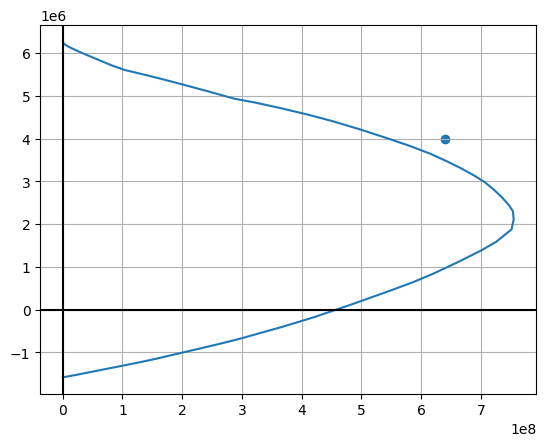

In [20]:
fig, axs = plt.subplots()
axs.plot(M_list[:,0], P_list)
axs.scatter(Mu, Pu)
axs.axhline(y=0, color='k', linestyle='-')
axs.axvline(x=0, color='k', linestyle='-')
axs.grid(True)
plt.show()

In [21]:
lbound = 0 if 0<= angle <90 else 90 if 90<= angle <180 else 180 if 180<= angle <270 else 270
ubound = 90 if 0<= angle <90 else 180 if 90<= angle <180 else 270 if 180<= angle <270 else 360
angle_list = np.linspace(lbound, ubound, 10)
Mxy_list = np.array([calc_Mn(data, Pu, _angle) for _angle in angle_list])

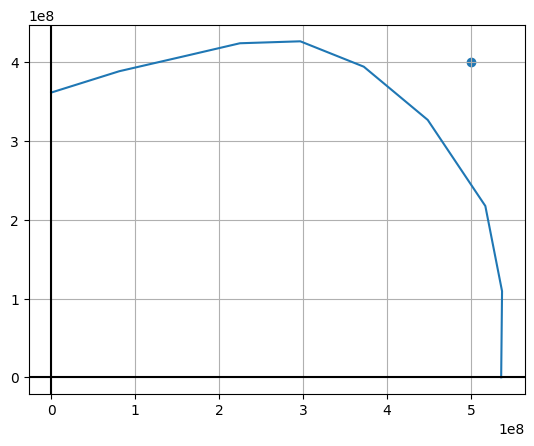

In [22]:
fig, axs = plt.subplots()
axs.plot(Mxy_list[:, 1], Mxy_list[:, 2])
axs.scatter(Mux, Muy)
axs.axhline(y=0, color='k', linestyle='-')
axs.axvline(x=0, color='k', linestyle='-')
axs.grid(True)
plt.show()

In [23]:
calc_percent(data, Pu, Mux, Muy)

array(1.71415166)

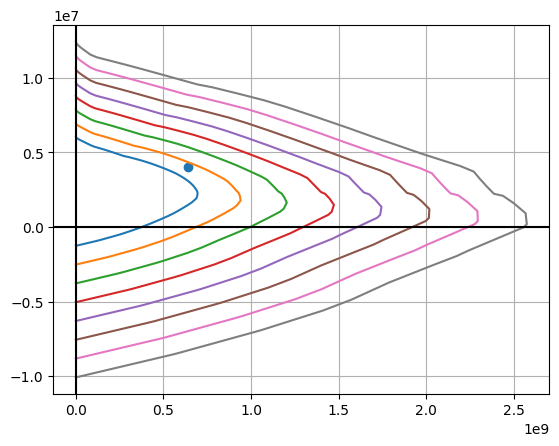

In [24]:
percent_list = np.linspace(1, 8, num=8)
data_list = np.array([PMManalysis.set_As_percent(data, percent) for percent in percent_list])

fig, axs = plt.subplots()
for _data in data_list:
    P_list, M_list = calc_PM_list(_data, angle)
    axs.plot(M_list[:,0], P_list)
axs.scatter(Mu, Pu)
axs.axhline(y=0, color='k', linestyle='-')
axs.axvline(x=0, color='k', linestyle='-')
axs.grid(True)
plt.show()